# Data Preprocessing

In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Define paths for train, valid, and test datasets
base_dir = "../data"
subsets = ["train", "valid", "test"]

# Global dictionaries
class_counts = Counter()
categories = {}  # To store category names
annotations = {}

# Function to process datasets
def process_dataset(subset):
    global categories  # Ensure global access
    image_dir = os.path.join(base_dir, subset)
    annotation_file = os.path.join(image_dir, "_annotations.coco.json")

    if not os.path.exists(annotation_file):
        print(f"⚠️ Annotation file missing: {annotation_file}")
        return

    with open(annotation_file, 'r') as f:
        coco_data = json.load(f)

    images = {img['id']: img for img in coco_data['images']}
    annotations = coco_data['annotations']

    # Initialize categories only once
    if not categories:
        categories = {cat['id']: cat['name'] for cat in coco_data['categories']}

    # Count bounding boxes per class
    for ann in annotations:
        class_counts[ann['category_id']] += 1

    print(f"📂 {subset.upper()} SET: {len(images)} images, {len(annotations)} annotations.")

# Run for all subsets
for subset in subsets:
    process_dataset(subset)

# Convert counts to an array of labels
all_labels = []
for class_id, count in class_counts.items():
    all_labels.extend([class_id] * count)

# Get sorted unique class IDs (ensure consistency)
unique_classes = sorted(class_counts.keys())

# Compute balanced class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(unique_classes),
    y=np.array(all_labels)
)

# Create a new dictionary with re-indexed class weights (starting from 0)
class_weight_dict = {i: weights[i] for i in range(len(weights))}

# Print the new class weights (re-indexed)
print("\n📊 Computed Class Weights (Re-indexed):")
for class_id, weight in class_weight_dict.items():
    class_name = categories.get(unique_classes[class_id], "Unknown")  # Use the original class ID for category name
    print(f"{class_name} (Re-indexed ID {class_id}): {weight:.4f}")

# Print bounding box count per class
print("\nBounding Box Count Per Class:")
for class_id, count in class_counts.items():
    class_name = categories.get(class_id, "Unknown")
    print(f"{class_name}: {count}")


📂 TRAIN SET: 270 images, 648 annotations.
📂 VALID SET: 24 images, 79 annotations.
📂 TEST SET: 33 images, 88 annotations.

📊 Computed Class Weights (Re-indexed):
insufficient light body (Re-indexed ID 0): 0.5251
non-continuous finish line (Re-indexed ID 1): 2.2147
uneven finish line (Re-indexed ID 2): 0.8419
void (Re-indexed ID 3): 2.1909

Bounding Box Count Per Class:
void: 93
non-continuous finish line: 92
insufficient light body: 388
uneven finish line: 242


2025-04-07 01:17:37.756031: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-04-07 01:17:49.184557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
15/15 [==============================] - 92s 5s/step - loss: 1.6692 - bbox_loss: 0.9943 - class_loss: 0.6749 - bbox_mae: 0.3417 - class_custom_accuracy: 0.1783 - val_loss: 2.0007 - val_bbox_loss: 0.9944 - val_class_loss: 1.0063 - val_bbox_mae: 0.3592 - val_class_custom_accuracy: 0.1339 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 79s 5s/step - loss: 1.5346 - bbox_loss: 0.9916 - class_loss: 0.5430 - bbox_mae: 0.3710 - class_custom_accuracy: 0.1835 - val_loss: 1.8901 - val_bbox_loss: 0.9938 - val_class_loss: 0.8963 - val_bbox_mae: 0.3651 - val_class_custom_accuracy: 0.1183 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 75s 5s/step - loss: 1.4797 - bbox_loss: 0.9907 - class_loss: 0.4890 - bbox_mae: 0.3548 - class_custom_accuracy: 0.3710 - val_loss: 1.9571 - val_bbox_loss: 0.9911 - val_class_loss: 0.9659 - val_bbox_mae: 0.3470 - val_class_custom_accuracy: 0.1540 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 74s 5s/step - l

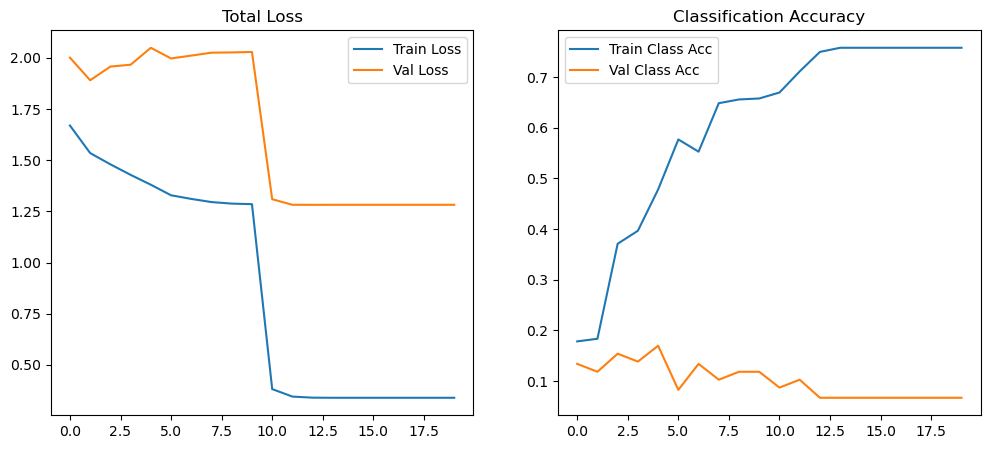

In [2]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.utils.class_weight import compute_class_weight

# -------------------------------
# Load Annotations
# -------------------------------
def load_annotations(path):
    with open(path, 'r') as f:
        return json.load(f)

# Paths
base_dir = "../data"
train_image_dir = os.path.join(base_dir, "train")
valid_image_dir = os.path.join(base_dir, "valid")
train_annotation_file = os.path.join(train_image_dir, "_annotations.coco.json")
val_annotation_file = os.path.join(valid_image_dir, "_annotations.coco.json")

train_annotations = load_annotations(train_annotation_file)
val_annotations = load_annotations(val_annotation_file)

# -------------------------------
# Reindex class IDs
# -------------------------------
original_class_ids = sorted(set(ann['category_id'] for ann in train_annotations['annotations']))
id_to_index = {orig_id: idx for idx, orig_id in enumerate(original_class_ids)}
index_to_id = {v: k for k, v in id_to_index.items()}

# -------------------------------
# Compute Class Weights
# -------------------------------
all_labels = [id_to_index[ann['category_id']] for ann in train_annotations['annotations']]
unique_classes = sorted(set(all_labels))

weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array(unique_classes),
    y=np.array(all_labels)
)
class_weight_dict = {i: weights[i] for i in range(len(weights))}

# -------------------------------
# Data Generator
# -------------------------------
class ObjectDetectionDataGenerator(Sequence):
    def __init__(self, annotations, image_dir, input_shape=(640, 640), batch_size=16, shuffle=True, max_objects=8):
        self.annotations = annotations
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.shuffle = shuffle
        self.max_objects = max_objects

        self.img_id_to_filename = {img['id']: img['file_name'] for img in annotations['images']}
        self.annotations_by_image = {}

        for ann in annotations['annotations']:
            img_id = ann['image_id']
            if img_id not in self.annotations_by_image:
                self.annotations_by_image[img_id] = []
            x, y, w, h = ann['bbox']
            ann['bbox'] = [x, y, x + w, y + h]
            self.annotations_by_image[img_id].append(ann)

        self.image_ids = list(self.annotations_by_image.keys())
        if self.shuffle:
            np.random.shuffle(self.image_ids)

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size: (idx + 1) * self.batch_size]
        images, bboxes, classes = [], [], []

        for img_id in batch_ids:
            img_path = os.path.join(self.image_dir, self.img_id_to_filename[img_id])
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            h, w, _ = image.shape
            anns = self.annotations_by_image[img_id]
            b = np.array([ann['bbox'] for ann in anns], dtype=np.float32)
            c = np.array([id_to_index[ann['category_id']] for ann in anns], dtype=np.int32)

            b[:, [0, 2]] /= w
            b[:, [1, 3]] /= h

            if len(b) > self.max_objects:
                b = b[:self.max_objects]
                c = c[:self.max_objects]

            b = np.pad(b, ((0, self.max_objects - len(b)), (0, 0)), constant_values=0)
            c = np.pad(c, (0, self.max_objects - len(c)), constant_values=0)

            images.append(image / 255.0)
            bboxes.append(b)
            classes.append(c)

        return np.array(images), (np.array(bboxes), np.array(classes))

# Generators
train_gen = ObjectDetectionDataGenerator(train_annotations, train_image_dir)
val_gen = ObjectDetectionDataGenerator(val_annotations, valid_image_dir)

max_objects = train_gen.max_objects
num_classes = len(unique_classes)

# -------------------------------
# Custom Loss and Metric
# -------------------------------
def weighted_sparse_categorical_crossentropy(class_weights):
    weights_tensor = tf.convert_to_tensor(
        [class_weights[i] for i in range(len(class_weights))], dtype=tf.float32)

    def loss(y_true, y_pred):
        weights = tf.gather(weights_tensor, y_true)
        base_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(base_loss * weights)

    return loss

def custom_accuracy(y_true, y_pred):
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int32)
    y_pred_classes = tf.cast(y_pred_classes, tf.int32)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    correct = tf.cast(tf.equal(y_true, y_pred_classes), tf.float32)
    correct *= mask
    return tf.reduce_sum(correct) / tf.reduce_sum(mask)

# -------------------------------
# Build Model
# -------------------------------
def build_model(input_shape=(640, 640, 3), max_objects=8, num_classes=10):
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, input_shape=input_shape, pooling='avg', weights='imagenet'
    )
    base_model._name = "mobilenetv2_base"
    base_model.trainable = False

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.Dense(256, activation='relu')(x)

    bbox_out = layers.Dense(4 * max_objects, activation='sigmoid')(x)
    bbox_out = layers.Reshape((max_objects, 4), name="bbox")(bbox_out)

    class_out = layers.Dense(max_objects * num_classes, activation='softmax')(x)
    class_out = layers.Reshape((max_objects, num_classes), name="class")(class_out)

    return tf.keras.Model(inputs=inputs, outputs=[bbox_out, class_out])

model = build_model(num_classes=num_classes, max_objects=max_objects)

# -------------------------------
# Compile & Train
# -------------------------------
import tensorflow_addons as tfa

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss={
        "bbox": tfa.losses.GIoULoss(mode='iou'),
        "class": weighted_sparse_categorical_crossentropy(class_weight_dict)
    },
    metrics={
        "bbox": ["mae"],
        "class": [custom_accuracy]
    }
)

def lr_scheduler(epoch, lr):
    return lr if epoch < 5 else (lr * 0.5 if epoch < 10 else lr * 0.1)

scheduler = callbacks.LearningRateScheduler(lr_scheduler)

# Initial Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[scheduler]
)

# Fine-Tuning
base_model = model.get_layer("mobilenetv2_base")
base_model.trainable = True

fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-4),
    loss={
        "bbox": tf.keras.losses.Huber(),
        "class": weighted_sparse_categorical_crossentropy(class_weight_dict)
    },
    metrics={
        "bbox": ["mae"],
        "class": [custom_accuracy]
    }
)

fine_tune_history = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=history.epoch[-1] + 1,
    epochs=20,
    callbacks=[scheduler]
)

model.save("../models/dental_fault_detector_mobilenet_finetuned.h5")

# Plot training history
def plot_history_combined(h1, h2):
    full_history = {}
    for key in h1.history:
        full_history[key] = h1.history[key] + h2.history[key]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(full_history['loss'], label="Train Loss")
    plt.plot(full_history['val_loss'], label="Val Loss")
    plt.title("Total Loss")
    plt.legend()

    if 'class_custom_accuracy' in full_history:
        plt.subplot(1, 2, 2)
        plt.plot(full_history['class_custom_accuracy'], label="Train Class Acc")
        plt.plot(full_history['val_class_custom_accuracy'], label="Val Class Acc")
        plt.title("Classification Accuracy")
        plt.legend()

    plt.show()

plot_history_combined(history, fine_tune_history)


In [3]:
# MODEL EVALUATION

# -------------------------------
# 1. Compute IoU & Accuracy for Full Test Set
# -------------------------------

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Define test data
test_image_dir = os.path.join(base_dir, "test")
test_annotation_file = os.path.join(test_image_dir, "_annotations.coco.json")

test_annotations = load_annotations(test_annotation_file)
test_gen = ObjectDetectionDataGenerator(
    test_annotations, test_image_dir, input_shape=(640, 640), max_objects=8
)

# Helper: Compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = max(0, x2 - x1) * max(0, y2 - y1)
    box2_area = max(0, x2g - x1g) * max(0, y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0.0

# Lists to collect results
all_true_classes = []
all_pred_classes = []
all_ious = []

# Evaluate model predictions
for images, (true_bboxes, true_classes) in test_gen:
    pred_bboxes, pred_class_probs = model.predict(images)
    pred_classes = np.argmax(pred_class_probs, axis=-1)

    for i in range(len(images)):
        true_boxes = true_bboxes[i] * 640
        pred_boxes = pred_bboxes[i] * 640

        for j in range(test_gen.max_objects):
            if not np.any(true_boxes[j]):
                continue
            iou = compute_iou(true_boxes[j], pred_boxes[j])
            all_ious.append(iou)

            all_true_classes.append(true_classes[i][j])
            all_pred_classes.append(pred_classes[i][j])

# Filter padded zeros
valid_mask = np.array(all_true_classes) != 0
filtered_true = np.array(all_true_classes)[valid_mask]
filtered_pred = np.array(all_pred_classes)[valid_mask]

# Metrics
acc = accuracy_score(filtered_true, filtered_pred)
f1 = f1_score(filtered_true, filtered_pred, average='weighted')
precision = precision_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
recall = recall_score(filtered_true, filtered_pred, average='weighted', zero_division=0)
mean_iou = np.mean(all_ious)

# Print results
print(f" Classification Accuracy: {acc:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" Mean IoU: {mean_iou:.4f}")

1/1 [==============================] - 1s 507ms/step
 Classification Accuracy: 0.2564
 Precision: 0.6937
 Recall: 0.2564
 F1 Score: 0.3590
 Mean IoU: 0.0247


In [4]:
print("First predicted box (normalised):", pred_bboxes[0][0])
print("First true box (normalised):", true_bboxes[0][0])


First predicted box (normalised): [0.3189233  0.35685438 0.609297   0.53965276]
First true box (normalised): [0.7046875  0.50625    0.765625   0.55078125]


1/1 [==============================] - 5s 5s/step


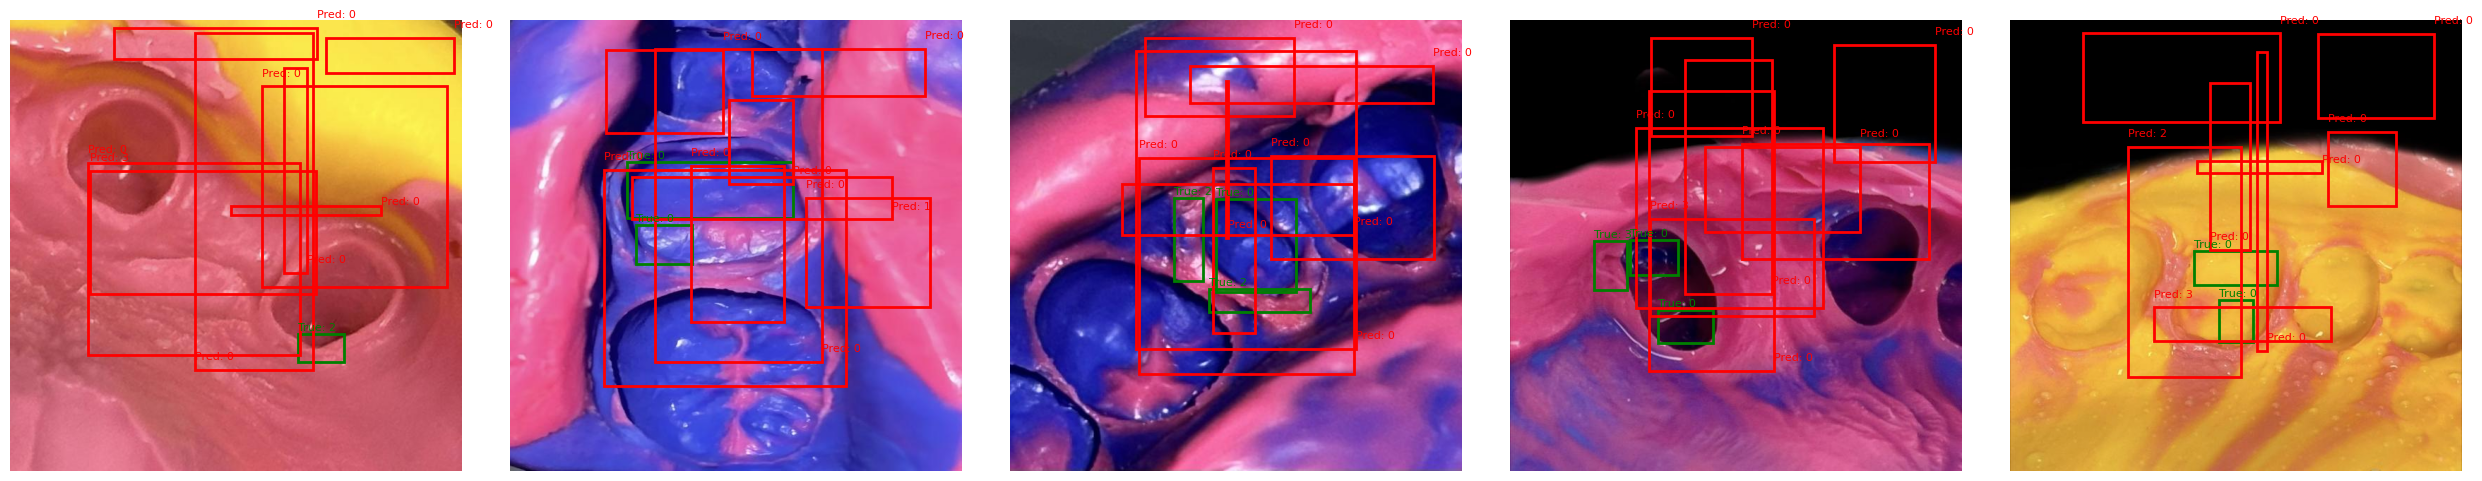

1/1 [==============================] - 0s 288ms/step


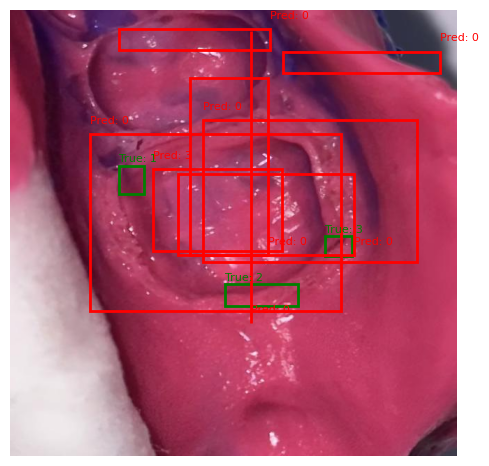

1/1 [==============================] - 6s 6s/step


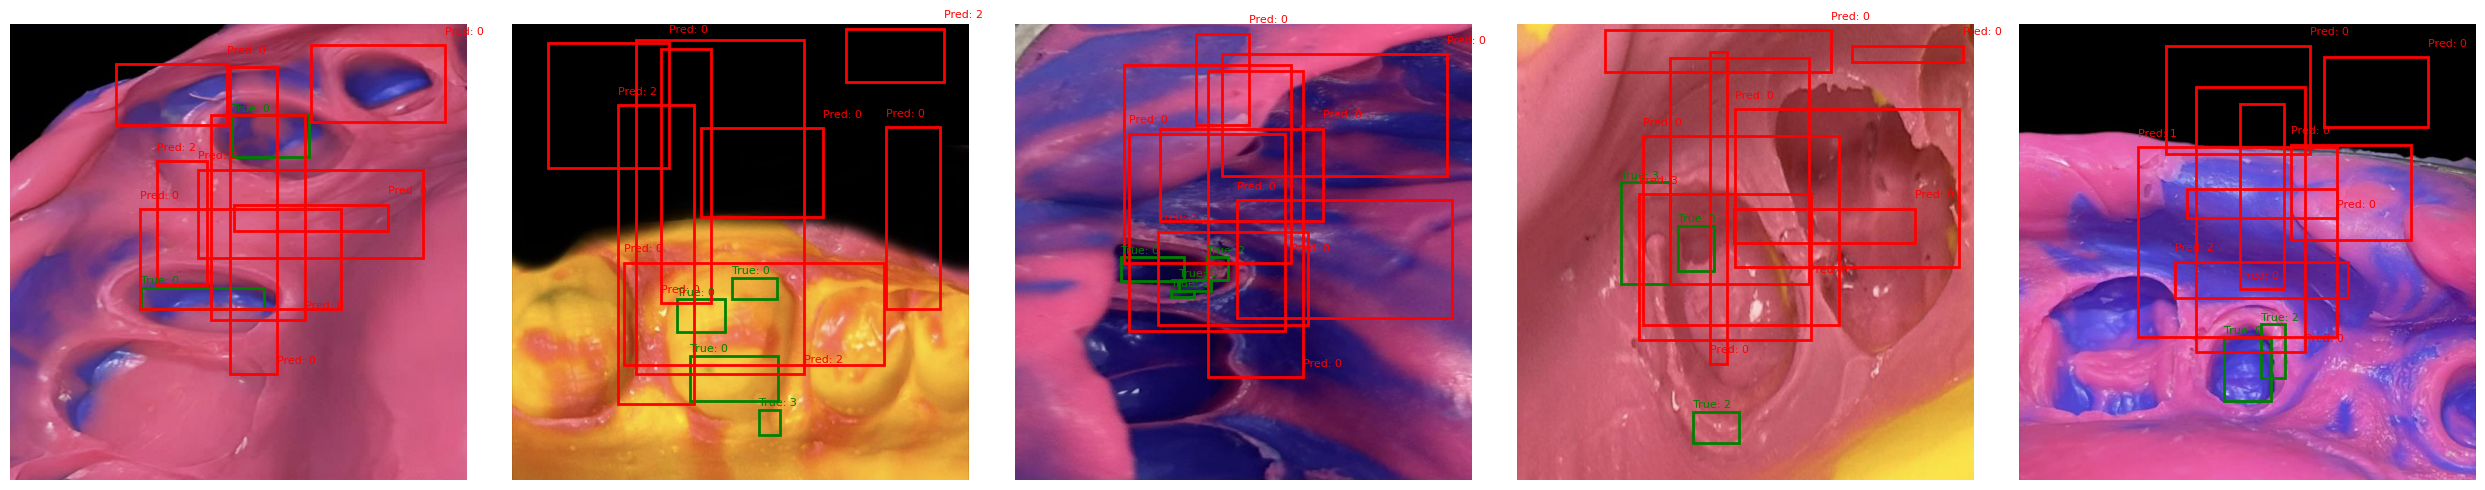

In [5]:
# -------------------------------
# 2. Visualise Random Predictions from Test Set
# -------------------------------

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

# Helper to denormalise bounding boxes
def denormalise_boxes(boxes, image_shape):
    h, w = image_shape
    boxes = boxes.copy()
    boxes[:, [0, 2]] *= w
    boxes[:, [1, 3]] *= h
    return boxes

# Plot function
def plot_predictions(images, true_bboxes, pred_bboxes, true_classes, pred_classes, num_samples=5):
    plt.figure(figsize=(num_samples * 5, 5))

    for i in range(min(num_samples, len(images))):
        img = (images[i] * 255).astype(np.uint8)
        fig_ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        ax = plt.gca()

        # Denormalise both true and predicted
        true_boxes_px = denormalise_boxes(true_bboxes[i], img.shape[:2])
        pred_boxes_px = denormalise_boxes(pred_bboxes[i], img.shape[:2])

        # True bounding boxes (green)
        for j in range(len(true_boxes_px)):
            if not np.any(true_boxes_px[j]):
                continue
            x1, y1, x2, y2 = true_boxes_px[j]
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='green', linewidth=2, fill=False)
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"True: {true_classes[i][j]}", color='green', fontsize=8)

        # Predicted bounding boxes (red)
        for j in range(len(pred_boxes_px)):
            if not np.any(pred_boxes_px[j]):
                continue
            x1, y1, x2, y2 = pred_boxes_px[j]
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', linewidth=2, fill=False)
            ax.add_patch(rect)
            ax.text(x1, y1 - 15, f"Pred: {pred_classes[i][j]}", color='red', fontsize=8)

        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show predictions from test generator
def show_random_test_predictions(num_samples=3):
    total_batches = len(test_gen)
    indices = random.sample(range(total_batches), min(num_samples, total_batches))

    for idx in indices:
        images, (true_bboxes, true_classes) = test_gen[idx]
        pred_bboxes, pred_probs = model.predict(images)
        pred_classes = np.argmax(pred_probs, axis=-1)

        plot_predictions(images, true_bboxes, pred_bboxes, true_classes, pred_classes,
                         num_samples=min(len(images), 5))

# Run it
show_random_test_predictions(3)


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
import os

# Define test data
test_image_dir = os.path.join(base_dir, "test")
test_annotation_file = os.path.join(test_image_dir, "_annotations.coco.json")

test_annotations = load_annotations(test_annotation_file)
test_generator = ObjectDetectionDataGenerator(test_annotations, test_image_dir, max_objects=8)

# Function to compute IoU (Intersection over Union)
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    box1, box2: [x_min, y_min, x_max, y_max]
    """
    x1, y1, x2, y2 = box1
    x1g, y1g, x2g, y2g = box2

    # Ensure valid boxes
    if x1 == x2 or y1 == y2 or x1g == x2g or y1g == y2g:
        return 0.0  # Invalid bounding box, return 0 IoU

    # Compute intersection
    xi1 = max(x1, x1g)
    yi1 = max(y1, y1g)
    xi2 = min(x2, x2g)
    yi2 = min(y2, y2g)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2g - x1g) * (y2g - y1g)

    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Function to evaluate model performance
def evaluate_model(model, generator, num_samples=10):
    ious = []
    for i in range(num_samples):
        images, (true_boxes, _) = generator[i]
        pred_boxes, _ = model.predict(images)

        for j in range(len(true_boxes)):
            gt_box = true_boxes[j][0]  # First ground truth bounding box
            pred_box = pred_boxes[j][0]  # First predicted bounding box
            iou = compute_iou(gt_box, pred_box)
            ious.append(iou)
            print(f"Sample {i}, IoU: {iou:.4f}")

    mean_iou = np.mean(ious)
    print(f"\nOverall Mean IoU: {mean_iou:.4f}")

# Load model if not already in memory
model_path = "../models/dental_fault_detector.h5"  # Replace with actual model path
model = tf.keras.models.load_model(model_path)

# Run model on test dataset
test_images, test_labels = next(iter(test_generator))  # Load test batch
predictions = model.predict(test_images)

# Extract predicted bounding boxes and class labels
pred_bboxes, pred_classes = predictions  # Shape: (batch_size, max_objects, 4) & (batch_size, max_objects, num_classes)
true_bboxes, true_classes = test_labels   # Ground truth

# Convert softmax class outputs to actual labels
pred_classes = np.argmax(pred_classes, axis=-1)  # (batch_size, max_objects)

# Compute bounding box regression error (MAE) - Ignore empty boxes
valid_boxes = np.any(true_bboxes != 0, axis=-1)  # Boolean mask for non-zero boxes
mae_bbox = np.mean(np.abs(pred_bboxes[valid_boxes] - true_bboxes[valid_boxes])) if np.any(valid_boxes) else 0

# Compute IoU for bounding box predictions - Ignore empty boxes
ious = []
for i in range(len(test_images)):  # Loop over batch
    for j in range(pred_bboxes.shape[1]):  # Loop over objects
        if np.all(true_bboxes[i][j] == 0):  # Ignore empty ground truth boxes
            continue
        iou = compute_iou(pred_bboxes[i][j], true_bboxes[i][j])
        ious.append(iou)

mean_iou = np.mean(ious) if len(ious) > 0 else 0

# Compute classification accuracy - Ignore empty labels
valid_classes = true_classes.flatten() > 0  # Filter valid labels
accuracy = accuracy_score(true_classes.flatten()[valid_classes], pred_classes.flatten()[valid_classes]) if np.any(valid_classes) else 0
f1 = f1_score(true_classes.flatten()[valid_classes], pred_classes.flatten()[valid_classes], average="weighted") if np.any(valid_classes) else 0

# Print Evaluation Metrics
print(f"Bounding Box Regression MAE: {mae_bbox:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Classification Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Function to visualize predictions
def plot_predictions(images, true_bboxes, pred_bboxes, true_classes, pred_classes, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(images[i].astype("uint8"))
        
        # True Bounding Box (Green)
        for j in range(true_bboxes.shape[1]):  # Loop over objects
            x_min, y_min, x_max, y_max = true_bboxes[i][j]
            if x_min == x_max:  # Skip invalid boxes
                continue
            width, height = x_max - x_min, y_max - y_min
            rect = plt.Rectangle((x_min, y_min), width, height, edgecolor="green", linewidth=2, fill=False)
            ax.add_patch(rect)
            ax.text(x_min, y_min - 5, f"True: {true_classes[i][j]}", color="green", fontsize=8)
        
        # Predicted Bounding Box (Red)
        for j in range(pred_bboxes.shape[1]):
            x_min, y_min, x_max, y_max = pred_bboxes[i][j]
            width, height = x_max - x_min, y_max - y_min
            rect = plt.Rectangle((x_min, y_min), width, height, edgecolor="red", linewidth=2, fill=False)
            ax.add_patch(rect)
            ax.text(x_min, y_min - 15, f"Pred: {pred_classes[i][j]}", color="red", fontsize=8)
        
        ax.axis("off")

    plt.show()

# Display some predictions
plot_predictions(test_images, true_bboxes, pred_bboxes, true_classes, pred_classes)


2025-04-06 21:24:22.694699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'base_dir' is not defined